##### imports

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 
#!pip install lifelines
import seaborn as sns
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats
from matplotlib.patches import Patch
import matplotlib.ticker as ticker



##### reading data

In [3]:
### reading data including individual tumour growth rates
df_all = pd.read_csv("clean_erlotinib.csv") # to see markers etc
total_tumors_df = pd.read_csv("total_tumors.csv")
single_tumors_df = pd.read_csv("single_tumors.csv")
total_tumors_df.head()
ten_plus_df = pd.read_csv("ten_plus.csv")

In [4]:
ten_plus_df.head()

,ID,days,Sum_tumor_lengths,Sum_tumor_volume,Dose_mg,ctDNA_copies_ml,Sum_tumor_vol_cm
0,A1002,0,58.7,43559.570202,0.0,0.0,43.559570
1,A1002,62,30.3,5243.630727,150.0,0.0,5.243631
2,A1002,110,24.1,4106.008715,150.0,0.0,4.106009
3,A1002,152,26.0,4417.875141,150.0,0.0,4.417875
4,A1002,187,26.0,4417.875141,150.0,0.0,4.417875


##### Logistic with competition coefficients

In [5]:
#  Logistic population model with alpha coefficients
def system_ode_logistic(time, populations, params):
    Spop = populations[0] # sensitive population at time t_0
    Rpop = populations[1] # resistant population at time t_0

    rS = params[0] #growth rate sensitive
    rR = params[1] #growth rate resistant
    alpha_SS = params[2] #interaction term sensitive on sensitive
    alpha_RR = params[3] #interaction term resistant on resistant
    alpha_SR = params[4] #interaction term effect of resistant on sensitive
    alpha_RS = params[5] #interaction term effect of sensitive on resistant
    K = params[6] #carrying capacity 
    Lambda_S = params[7] #sensitivity to medication of sensitive population
    m= 1 # dose 

# equations 
    dSpop_dt = rS*Spop*(1-(Spop*alpha_SS + Rpop*alpha_SR)/K)*(1-Lambda_S*m)
    dRpop_dt = rR*Rpop*(1-(Rpop*alpha_RR + Spop*alpha_RS)/K)

    return [dSpop_dt, dRpop_dt]


# Cost function
def cost_func_logistic(params, time, data, error_metric='rmse', delta = 10):
    initial_populations = params[8:]
    tspan = [time[0], time[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = tuple([params[:8]]))
    
    if pred_data_log.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        delta = delta
        huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
        mean_abs_error = 1e30
        huber_loss = 1e30

    if error_metric == 'mean_abs_error':
        return mean_abs_error
    elif error_metric == 'msq_error':
        return msq_error
    elif error_metric == 'rmse':
        return rmse
    elif error_metric == 'huber_loss':
        return huber_loss
    else:
        raise ValueError(f"Invalid error_metric: {error_metric}")
   


##### running model

In [15]:
#### use ten plus tumors df
df = ten_plus_df
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    max_value = max(data[0], data[-1])
    print("Working on patient:", id, " Number of data points:", len(days))
    bounds =   [(1e-4, 1e-2),#rs
                (1e-4, 1e-2),#rr
                (0.0, 10),#alpha_SS
                (0.0, 10),#alpha_RR
                (0.0, 10),#alpha_SR
                (0.0, 10),#alpha_RS
                (1.5*max_value, 20*max_value),#K
                (1, 200),#lambda_S
                (0.8*data[0], 1.1*data[0]),# S_0
                (1e-1,0.3*data[0])] # R_0

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, args=(days, data,'rmse')
    , strategy='best1bin',
    maxiter=1000, popsize=100, disp=True, polish=True) 
     #,init='latinhypercube', updating='deferred', workers=-1)
  
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
differential_evolution step 1: f(x)= 4.52974
differential_evolution step 2: f(x)= 4.52974
differential_evolution step 3: f(x)= 4.50209
differential_evolution step 4: f(x)= 4.50209
differential_evolution step 5: f(x)= 4.44477
differential_evolution step 6: f(x)= 4.4224
differential_evolution step 7: f(x)= 4.31622
differential_evolution step 8: f(x)= 4.31622
differential_evolution step 9: f(x)= 4.31622
differential_evolution step 10: f(x)= 4.31622
differential_evolution step 11: f(x)= 4.31622
differential_evolution step 12: f(x)= 4.31622
differential_evolution step 13: f(x)= 4.31622
differential_evolution step 14: f(x)= 4.3125
differential_evolution step 15: f(x)= 4.30788
differential_evolution step 16: f(x)= 4.30788
differential_evolution step 17: f(x)= 4.25264
differential_evolution step 18: f(x)= 4.25264
differential_evolution step 19: f(x)= 4.18069
differential_evolution step 20: f(x)= 4.18069
differential_evolution step 21: f(x)= 

In [16]:
df_log = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['rs', 'rr', 'alpha_SS', 'alpha_RR',
                                      'alpha_SR', 'alpha_RS', 'K', 'lambda_S', 
                                      'S_0', 'R_0', 'error'])

df_log 

,rs,rr,alpha_SS,alpha_RR,alpha_SR,alpha_RS,K,lambda_S,S_0,R_0,error
A1002,0.003363,0.010000,0.000000,0.000000,7.698204,9.742515,87.092681,9.527744,43.108483,0.101827,3.661172
A1007,0.000702,0.010000,0.000000,7.745033,8.486295,0.000000,120.029971,92.927881,31.848696,8.314379,1.568078
A1008,0.000414,0.001256,9.145334,0.142337,5.175570,5.775731,372.941959,131.319548,33.298482,5.052711,0.810617
A1012,0.000480,0.010000,2.929977,7.686188,0.768244,4.802934,186.484098,40.534962,40.560570,9.493183,4.374682
A1014,0.004307,0.000546,0.009740,0.384695,9.255250,7.605602,1.316136,83.306091,0.728430,0.100426,0.045811
A1016,0.001825,0.001446,0.264644,0.806457,7.496737,8.448329,1991.501033,38.331130,99.914742,4.349959,0.848652
E1012,0.000788,0.010000,4.133119,9.711787,0.149137,5.752786,92.833016,31.582428,20.760914,5.141201,0.483313


In [17]:
df_log2 = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['rs', 'rr', 'alpha_SS', 'alpha_RR',
                                      'alpha_SR', 'alpha_RS', 'K', 'lambda_S', 
                                      'S_0', 'R_0', 'error'])

df_log2 

,rs,rr,alpha_SS,alpha_RR,alpha_SR,alpha_RS,K,lambda_S,S_0,R_0,error
A1002,0.003363,0.010000,0.000000,0.000000,7.698204,9.742515,87.092681,9.527744,43.108483,0.101827,3.661172
A1007,0.000702,0.010000,0.000000,7.745033,8.486295,0.000000,120.029971,92.927881,31.848696,8.314379,1.568078
A1008,0.000414,0.001256,9.145334,0.142337,5.175570,5.775731,372.941959,131.319548,33.298482,5.052711,0.810617
A1012,0.000480,0.010000,2.929977,7.686188,0.768244,4.802934,186.484098,40.534962,40.560570,9.493183,4.374682
A1014,0.004307,0.000546,0.009740,0.384695,9.255250,7.605602,1.316136,83.306091,0.728430,0.100426,0.045811
A1016,0.001825,0.001446,0.264644,0.806457,7.496737,8.448329,1991.501033,38.331130,99.914742,4.349959,0.848652
E1012,0.000788,0.010000,4.133119,9.711787,0.149137,5.752786,92.833016,31.582428,20.760914,5.141201,0.483313


##### Plotting

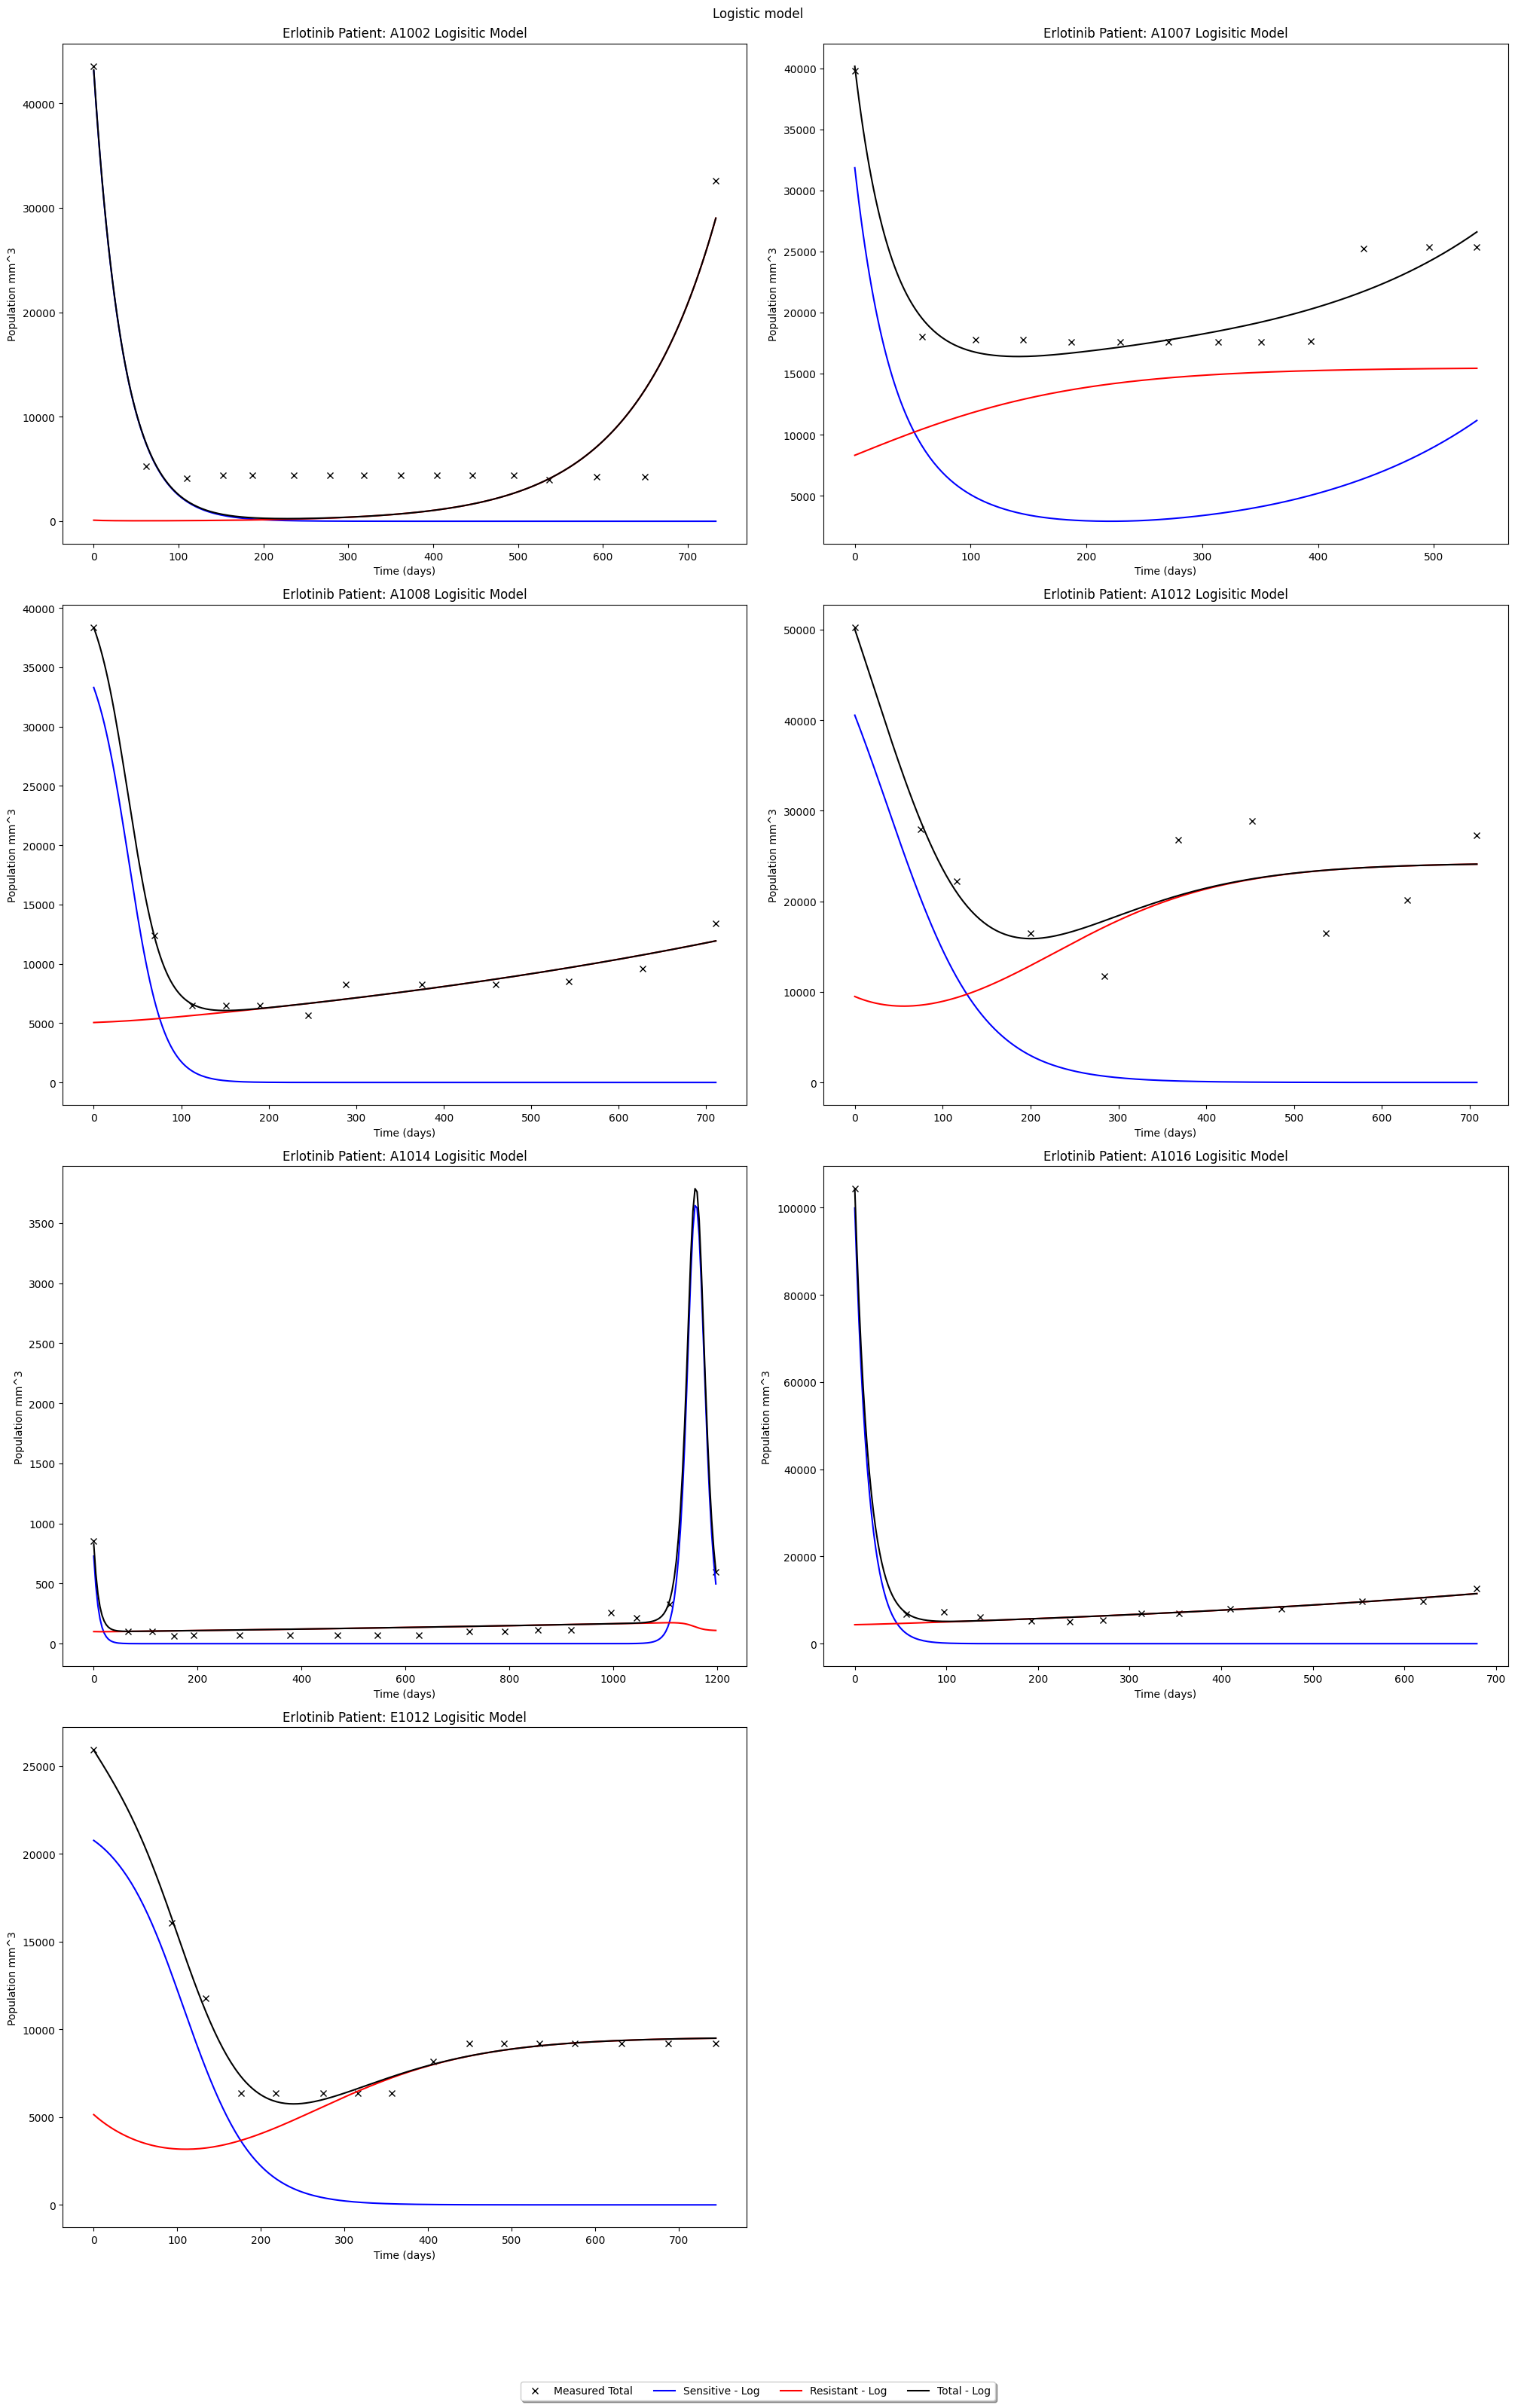

In [18]:
# setting up subplots
df = ten_plus_df
unique_IDs = df.ID.unique()   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[8:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:8]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {id} Logisitic Model') 
    formatter = ticker.FuncFormatter(lambda x, pos: '%d' % (x * 1e3))
    ax.yaxis.set_major_formatter(formatter)

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### extending time

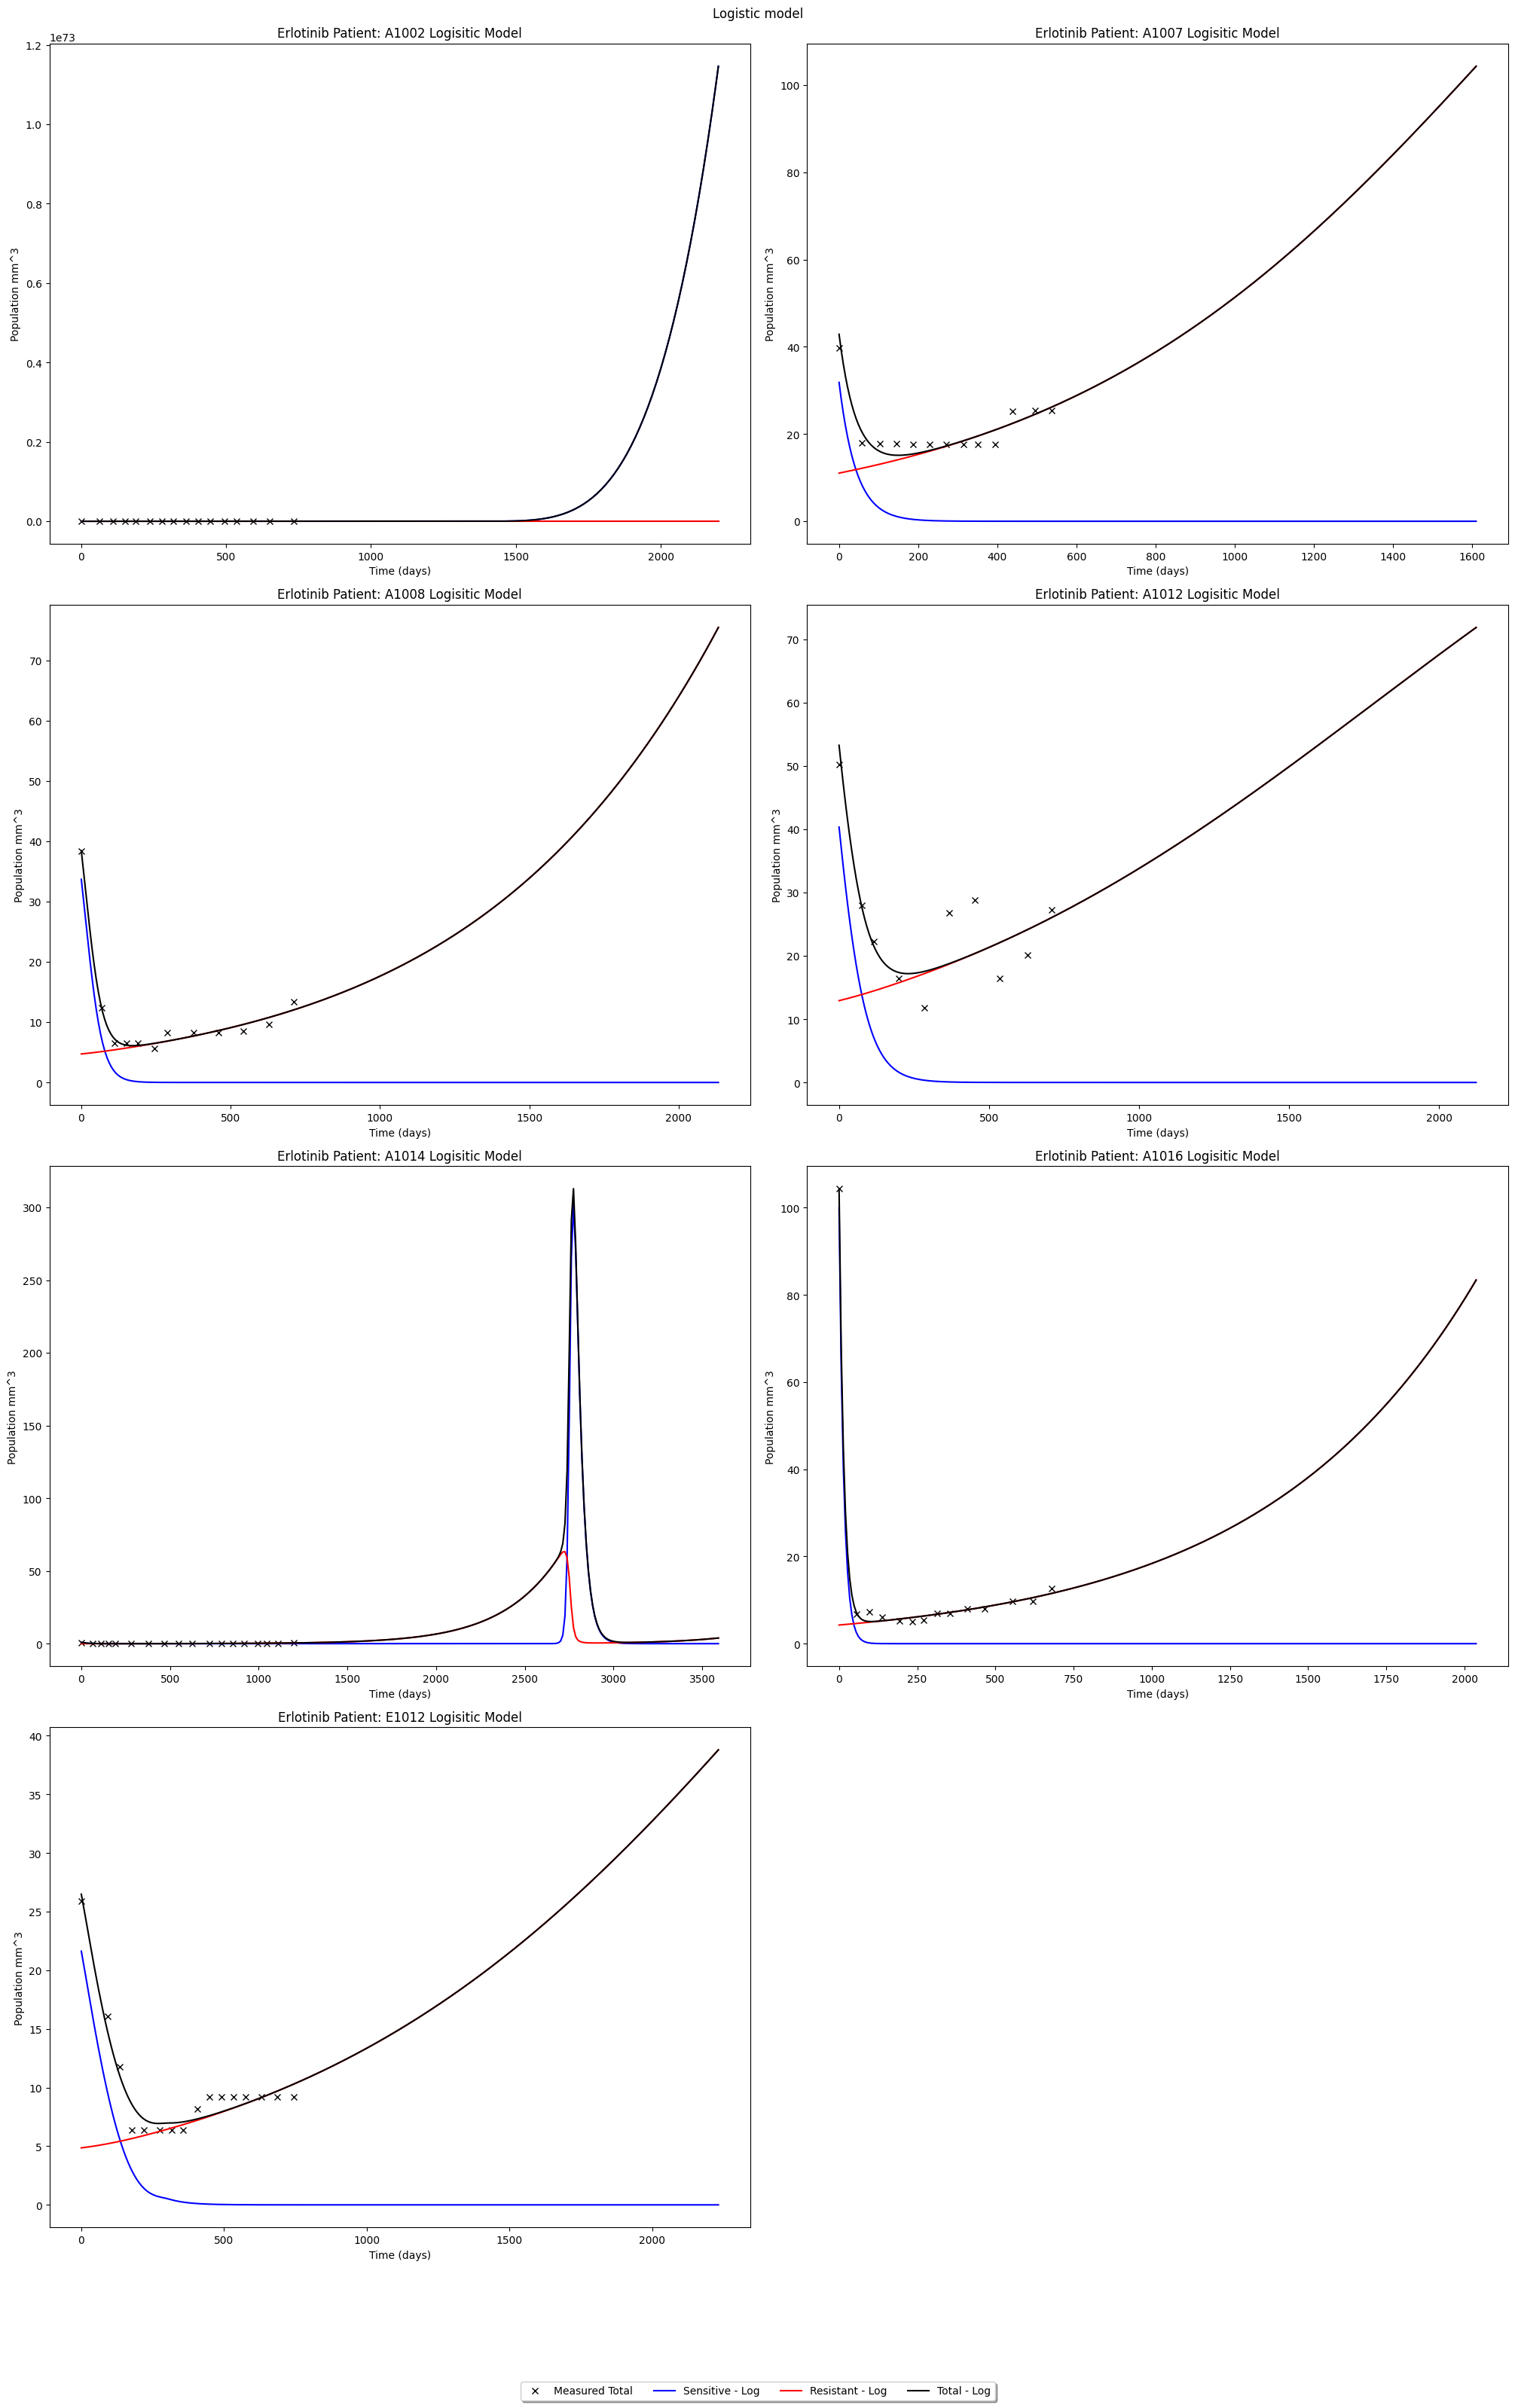

In [14]:
sim_time_factor = 3
df = ten_plus_df
unique_IDs = df.ID.unique()  
# setting up subplots
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[8:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:8]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {id} Logisitic Model') 
    # formatter = ticker.FuncFormatter(lambda x, pos: '%d' % (x * 1e3))
    # ax.yaxis.set_major_formatter(formatter)

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()